In [19]:
!ls

Colours_weights from 1-10_10 is best match_1 is worst match.xlsx
Materials_weights from 1-10_10 is best match_1 is worst match.xlsx
Processing dresses data.ipynb
Segmented Information.pdf
Simplified_Garments and their parts copy.xlsx


In [20]:
import xlrd 
import re
from pprint import pprint
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt

In [21]:
def read_xls(filepath):
    book  = xlrd.open_workbook(filepath)
    sheet = book.sheet_by_index(0)
    return sheet


In [22]:
def create_map_column2type(row):
    index2type = {}
    for index, element in enumerate(row):
        if element.value:
            index2type[index] = element.value.strip()
    return index2type

In [23]:
def is_empty_row(row):
    '''heuristics to detect empty rows: if cols 1-4 are empty, it is an empty row'''
    return all(x.value == "" for i, x in enumerate(row) if i > 1) # if we see a bunch of none 

In [24]:
def create_record(row, index2type, dress2parts, index_mandatory):
    dress_type    = row[0].value.strip()
    dress_subtype = row[1].value.strip()
    for index, element in enumerate(row):
        if index > 1:
            if element.value:
                dress2parts[dress_subtype].append((index2type[index],index_mandatory[index]))

In [25]:
def create_mandatory_optional_mapping(row, index2subtype):
    index_mandatory  = {}
    subtype_optional = {}
    for index, element in enumerate(row):
        if index <= 1:
            continue
        is_optional = element.value.strip() == "Mandatory"
        index_mandatory[index] = is_optional
        subtype_optional[index2subtype[index]] = is_optional
    return index_mandatory, subtype_optional

In [26]:
def parse_garmet_sheet(sheet):
    flag_type2index = True
    flag_subtype2index = True
    optional_flag    = True
    dress2parts     = defaultdict(list)
    index2col       = {}

    for index, row in enumerate(sheet.get_rows()):
        if not is_empty_row(row):
            if flag_type2index:
                index2type = create_map_column2type(row)
                flag_type2index = False
            elif flag_subtype2index:
                index2subtype = create_map_column2type(row)
                flag_subtype2index = False
                for key in index2type.keys():
                    index2col[key] = index2subtype[key]
            elif optional_flag:
                optional_flag    = False
                index_mandatory, subtype_optional = create_mandatory_optional_mapping(row, index2subtype)
            else: # process the data itself
                create_record(row, index2col, dress2parts, index_mandatory)
    return {sheet.name.lower(): dress2parts}

In [27]:
def read_choices(sheet):
    name2minmax = {}
    for index, row in enumerate(sheet.get_rows()):
        if index > 0:
            name2minmax[row[0].value.strip().lower()] = (int(row[1].value),int(row[2].value))
    return name2minmax

In [28]:
def read_garmet_parts():
    book = xlrd.open_workbook("Simplified_Garments and their parts copy.xlsx")
    special_list = ["Optional choices"]
    sheets = [book.sheet_by_name(name) for name in book._sheet_names if name not in special_list]
    parts2dress = {}
    for sheet in sheets:
        print(f"processing {sheet.name}")
        parts2dress.update(parse_garmet_sheet(sheet))
    choices = read_choices(book.sheet_by_name("Optional choices"))
    dress2parts = defaultdict(dict)
    for garmet_part in parts2dress.keys():
        for key in parts2dress[garmet_part].keys():
            dress2parts[key].update({garmet_part:parts2dress[garmet_part][key]})
    return dress2parts, choices

In [29]:
dress2parts, choices = read_garmet_parts()

processing Collar
processing Upper front panel
processing Upper back panel
processing Upper details
processing Sleeve
processing Sleeve details
processing Skirt
processing Skirt details
processing Leg
processing Leg details
processing Other


In [30]:
choices

{'collar': (1, 1),
 'upper details': (0, 3),
 'upper back panel': (1, 1),
 'upper front panel': (1, 1),
 'sleeve details': (0, 3),
 'sleeve': (1, 1),
 'skirt': (1, 1),
 'skirt details': (0, 3),
 'leg': (1, 2),
 'leg details': (0, 3),
 'other': (0, 5)}

In [31]:
dress2parts['Blazer']

{'collar': [('Collar', True),
  ('Stand collar', False),
  ('Shawl collar', False),
  ('Wing collar', False),
  ('Lapel collar', False),
  ('neckline', False),
  ('Hood', False)],
 'upper front panel': [('Loose upper front panel', False),
  ('Tight upper front panel', False),
  ('Bodice front', False),
  ('Waterfall front', False)],
 'upper back panel': [('Loose upper back panel', False),
  ('Tight upper back panel', False),
  ('Bodice back', False)],
 'upper details': [('Breast pocket', False),
  ('waistband', False),
  ('Breast', False),
  ('shoulder', False),
  ('Shoulder pad', False),
  ('Tie', False),
  ('Fly', False)],
 'sleeve': [('Sleeve', True),
  ('Puffy sleeve', False),
  ('Wide sleeve', False),
  ('Skinny sleeve', False),
  ('Kimono sleeve', False),
  ('Bat sleeve', False)],
 'sleeve details': [('cuffs', False),
  ('Cuff buttons', False),
  ('elbow', False),
  ('Cuff slit', False)],
 'skirt details': [('Coat tails', False)],
 'leg details': [('vent', False)],
 'other': [('p

In [32]:
def create_simple_record(row, index2color, colors_match):
    for index, element in enumerate(row):
        if index == 0:
            color = element.value.strip()
            colors_match[color] = {}
        else:
            if element.value:
                try:
                    colors_match[color][index2color[index]] = int(re.search(r'\d+', str(element.value)).group())
                except:
                    print("error", element.value)
            else:
                 colors_match[color][index2color[index]]= 0
    

In [33]:
def read_color_match():  
    sheet = read_xls("Colours_weights from 1-10_10 is best match_1 is worst match.xlsx")
    header_row = True
    colors_match = {}
    for index, row in enumerate(sheet.get_rows()):
        if not is_empty_row(row):
            if row[0].value == "Colours":
                index2color = create_map_column2type(row)
            else:
                create_simple_record(row, index2color, colors_match)
    return colors_match

In [34]:
colors_match = read_color_match()

In [35]:
def post_process(dict_match):
    tuple_matrix  = []
    main_elements = []
    for element1 in dict_match.keys():
        main_elements.append(element1)
        for element2 in dict_match[element1].keys():
            tuple_matrix.append((element1, element2, dict_match[element1][element2]))
            tuple_matrix.append((element2, element1, dict_match[element1][element2]))
    return main_elements, set(tuple_matrix)

In [36]:
def read_material_match():
    sheet = read_xls("Materials_weights from 1-10_10 is best match_1 is worst match.xlsx")
    header_row = True
    material_match = {}
    for index, row in enumerate(sheet.get_rows()):
        if not is_empty_row(row):
            if "Materials" in row[0].value:
                index2material = create_map_column2type(row)
            else:
                create_simple_record(row, index2material, material_match)
    return material_match

In [37]:
material_match = read_material_match()

In [38]:
material_match

{'Brocade': {'Batik': 5,
  'Brocade': 10,
  'Calico': 0,
  'Camel Hair': 0,
  'Canvas': 0,
  'Cashmere': 0,
  'Chiffon': 0,
  'Corduroy': 0,
  'Cotton': 0,
  'Crash': 0,
  'Crepe': 0,
  'Crepe De Chine': 0,
  'Damask': 0,
  'Delaine': 0,
  'Denim': 0,
  'Fake Fur': 0,
  'Feathers': 0,
  'Felt': 0,
  'Fishnet': 0,
  'Flannel': 0,
  'Flax': 0,
  'Fleece': 0,
  'Fur': 0,
  'Gabardine': 0,
  'Gauze': 0,
  'Gingham': 0,
  'Grosgrain': 0,
  'Hemp': 0,
  'Horsehair': 0,
  'Jersey': 0,
  'Jute': 0,
  'Lace': 0,
  'Latex': 0,
  'Leather': 0,
  'Linen': 0,
  'Metal': 0,
  'Mohair': 0,
  'Muslin': 0,
  'Plastic': 0,
  'Polyester': 0,
  'Poplin': 0,
  'Pvc': 0,
  'Rabbit Hair': 0,
  'Rayon': 0,
  'Reticella': 0,
  'Rubber': 0,
  'Silicone': 0,
  'Satin': 0,
  'Silk': 0,
  'Taffeta': 0,
  'Tweed': 0,
  'Twill': 0,
  'Velvet': 0,
  'Wool': 0},
 'Calico': {'Batik': 5,
  'Brocade': 4,
  'Calico': 6,
  'Camel Hair': 0,
  'Canvas': 0,
  'Cashmere': 0,
  'Chiffon': 0,
  'Corduroy': 0,
  'Cotton': 0,
  'C

In [39]:
main_colors, color_tuples = post_process(colors_match) # symmetry enforcing operation
main_materials, material_tuples = post_process(material_match) # symmetry enforcing operation

In [40]:
heavy_tail_color_weights = np.array([1, 4, 3, 2, 1,])
color_probabilities = heavy_tail_color_weights/sum(heavy_tail_color_weights)
heavy_tail_material_weights = np.array([1, 6, 5, 1])
material_probabilities = heavy_tail_material_weights/sum(heavy_tail_material_weights)

In [41]:
# material probabilites

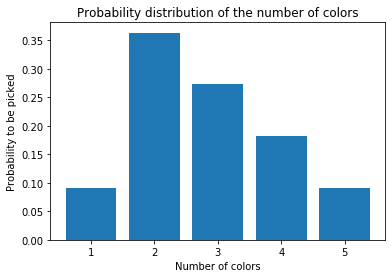

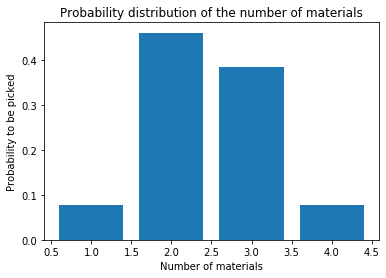

In [42]:
plt.figure()
plt.bar(np.arange(1, len(color_probabilities)+1), color_probabilities)
plt.xlabel("Number of colors")
plt.ylabel("Probability to be picked")
plt.title("Probability distribution of the number of colors")
plt.show()
plt.figure()
plt.bar(np.arange(1, len(material_probabilities)+1), material_probabilities)
plt.xlabel("Number of materials")
plt.ylabel("Probability to be picked")
plt.title("Probability distribution of the number of materials")
plt.show()

In [43]:
def pick_the_number_from_prob_array(prob_array):
    return np.random.choice(np.arange(1, len(prob_array)+1), p=prob_array)

In [44]:
colors_match.keys()

dict_keys(['Red light', 'Red dark', 'Orange normal', 'Orange light', 'Orange dark', 'Yellow normal', 'Yellow light', 'Yellow dark', 'Green normal', 'Green light', 'Green dark', 'Blue normal', 'Blue light', 'Blue dark', 'Purple normal', 'Purple light', 'Purple dark', 'Pink normal', 'Pink light', 'Pink dark', 'Brown normal', 'Brown light', 'Brown dark', 'Gray normal', 'Gray light', 'Gray dark', 'Black', 'White'])

In [45]:
def pick_n_best(number_to_pick, main_elements, weights):
    main_element = np.random.choice(main_elements, size=1)[0] # ok pick the main color
    elements = list(filter(lambda x: x[0] == main_element, weights)) # remove all weights that are not related to the main color
    sorted_by_match = sorted(elements,reverse=True, key=lambda x: x[2]) # sort by weight
    output = list(filter(lambda x: x[2] > 0, sorted_by_match[:number_to_pick]))
    output_elements = list(map(lambda x: x[1],output))
    if main_element not in output_elements:
        output_elements = [main_element] + output_elements[:-1]
    return main_element, output_elements

In [46]:
def generate_colors_and_materials(color_probabilities, material_probabilities, color_tuples, material_tuples):
    number_of_colors = pick_the_number_from_prob_array(color_probabilities)
   # print(f"number of colors: {number_of_colors}")
    number_of_materials = pick_the_number_from_prob_array(material_probabilities)
   # print(f"number of materials: {number_of_materials}")
    main_color, colors_output = pick_n_best(number_of_colors, main_colors, color_tuples)
  #  print(f"main color: {main_color}")
 #   print(colors_output)
    main_material, material_output = pick_n_best(number_of_materials, main_materials, material_tuples)
  #  print(f"main material: {main_material}")
  #  print(material_output)
    return main_color, colors_output, main_material, material_output


In [47]:
main_color, colors_output, main_material, material_output = generate_colors_and_materials(color_probabilities, material_probabilities, color_tuples, material_tuples)

In [48]:
choices

{'collar': (1, 1),
 'upper details': (0, 3),
 'upper back panel': (1, 1),
 'upper front panel': (1, 1),
 'sleeve details': (0, 3),
 'sleeve': (1, 1),
 'skirt': (1, 1),
 'skirt details': (0, 3),
 'leg': (1, 2),
 'leg details': (0, 3),
 'other': (0, 5)}

In [49]:
def generate_choice_fixed_numbers(choice_ranges):
    probabilities = {}
    number_weights = np.array([1, 3, 3, 2, 1, 1,]) # 0, 5
    probabilities[(0,5)] = number_weights/sum(number_weights)
    number_weights = np.array([1, 3, 3, 1, 1]) # 0, 4
    probabilities[(0,4)] = number_weights/sum(number_weights)
    number_weights = np.array([1, 3, 2, 1]) # 0, 3
    probabilities[(0,3)] = number_weights/sum(number_weights)
    number_weights = np.array([1, 3, 1, ]) # 0, 2
    probabilities[(0,2)] = number_weights/sum(number_weights)
    number_weights = np.array([1, 1,]) # 0, 1
    probabilities[(0,1)] = number_weights/sum(number_weights)
    number_weights = np.array([2, 1,]) # 1, 2
    probabilities[(1,2)] = number_weights/sum(number_weights)
    numbers = {}
    for key in choice_ranges.keys():
        low, high = choice_ranges[key]
        if low == high:
            numbers[key] = low
        else:
            numbers[key] = pick_the_number_from_prob_array(probabilities[(low,high)])
    return numbers
         


In [50]:
def generate_dress_parts(dress2parts, choices):
    # generating garmets
    fixed_number_choice = generate_choice_fixed_numbers(choices)
    dress_name = np.random.choice(list(dress2parts.keys()), size=1)[0]
    parts = dress2parts[dress_name]
    dress_parts = defaultdict(list)
    for key, garmet_elements in parts.items():
        number_to_pick = fixed_number_choice[key]
        for element in garmet_elements:
            required     = list(map(lambda x: x[0], filter(lambda x: x[1] == True,  garmet_elements)))
            optional_all = list(map(lambda x: x[0], filter(lambda x: x[1] == False, garmet_elements)))
            optional     = list(np.random.choice(optional_all, number_to_pick))
            dress_parts[key] = set(required+optional)
    return dress_name, dress_parts

In [51]:
def generate_dress(dress2parts, choices, color_probabilities, material_probabilities, color_tuples, material_tuples):
    dress_name, dress_parts = generate_dress_parts(dress2parts, choices)
    main_color, colors_output, main_material, material_output = generate_colors_and_materials(color_probabilities, material_probabilities, color_tuples, material_tuples)
    return dress_name, dress_parts, main_color, colors_output, main_material, material_output

In [54]:
with open("dresses.txt", "w") as outputfile:
    for i in range(100):
        print(10*"=", file=outputfile)
        print(f"generating dress number {i}", file=outputfile)
        dress_name, dress_parts, main_color, colors_output, main_material, material_output = generate_dress(dress2parts, choices, color_probabilities, material_probabilities, color_tuples, material_tuples)
        print(f"{dress_name}", file=outputfile)
        print("parts:", file=outputfile)
        pprint(dict(dress_parts), outputfile)
        print(f"main color: {main_color}", file=outputfile)
        print("all colors", file=outputfile)
        print(colors_output, file=outputfile)
        print(f"main material: {main_material}", file=outputfile)
        print("all materials", file=outputfile)
        print(material_output, file=outputfile)
